# Simulação Drone 2D

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]


In [ ]:
def x_dot(t, x, w_):
    # State vector
    # x = [ w r_xy v_xy phi omega]' \in R^8

    #print('x: ', x)
    #print('w_: ', w_)

    ## Parâmetros
    w_max = 15000. # velocidade máxima do motor
    m = 0.25 # massa
    g = 9.81 # aceleração da gravidade
    l = 0.1  # tamanho
    kf = 1.744e-08 # constante de força
    Iz = 2e-4  # momento de inércia
    tal = 0.005
    P  = np.array([[0],\
                   [-m*g]])


    ## Estados atuais
    w = x[0:2]
    r = x[2:4]
    v = x[4:6]
    phi = x[6]
    ome = x[7]

    ## Variáveis auxiliares

    # forças
    f1 = kf * w[0]**2
    f2 = kf * w[1]**2

    # Torque
    Tc = l * (f1 - f2)

    # Força de controle
    Fc_B = np.array( [[0], \
                     [(f1 + f2)]])
    # Matriz de atitude
    D_RB = np.array([ [ np.cos(phi), -np.sin(phi)],  \
                      [ np.sin(phi),  np.cos(phi)]])


    ## Derivadas
    w_dot = (-w + w_)/tal
    r_dot = v
    v_dot = (1/m)*(D_RB @ Fc_B + P)
    v_dot = v_dot.reshape(2,)
    phi_dot = np.array([ome])
    ome_dot = np.array([Tc/Iz])

    xkp1 = np.concatenate([ w_dot, \
                            r_dot, \
                            v_dot, \
                            phi_dot,\
                            ome_dot ])
    return xkp1

In [ ]:
# Runge Kutta de 4ª órdem

def rk4(tk, h, xk, uk):

    k1 = x_dot(tk        , xk           , uk)
    k2 = x_dot(tk + h/2.0, xk + h*k1/2.0, uk)
    k3 = x_dot(tk + h/2.0, xk + h*k2/2.0, uk)
    k4 = x_dot(tk + h    , xk + h*k3    , uk)

    xkp1 = xk +(h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return xkp1

In [ ]:
# PARÂMETROS DE SIMULAÇÃO

h  = 1e-3   # passo da simulação de tempo continuo
Ts = 10e-3   # intervalo de atuação do controlador
fTh = Ts/h
maxT = 60
tc = np.arange(0,maxT,h)   # k
td = np.arange(0,maxT,Ts)  # j
tam = len(tc)
j = 0

# Vetor de estados
# State vector
# x = [ w r_xy v_xy phi omega]' \in R^8
x = np.zeros([8, tam])
#x[:,0] = np.array([0.,1.,2,3,4,5,6,7,])
x[:,0] = np.array([0., 0., \
                   0., 0., \
                   0., .0, \
                   0*np.pi/180., \
                   0*np.pi/180.])

In [ ]:
# Parâmetros do sistema de controle
# Vetor de controle relativo à rotação
w_   = np.zeros([2,len(td)])  # comando de controle
Phi_ = np.zeros([1,len(td)])  # comando de Atitude
WP_  = np.zeros([2,len(td)])  # comando de Waypoint

# Vetor dos erros de posição
eP_   = np.zeros([2,len(td)])
eV_   = np.zeros([2,len(td)])
ePhi_ = np.zeros([1,len(td)])
eOme_ = np.zeros([1,len(td)])

ePm1 = 0  # erro posição k-1 (passo anterior)
eVm1 = 0  # erro atitude k-1 (passo anterior)

# Constanstes do modelo
m = 0.25 # massa
g = 9.81 # aceleração da gravidade
l = 0.1  # tamanho
kf = 1.744e-08 # constante de força
Iz = 2e-4  # momento de inércia
tal = 0.05
Fe = np.array([-m*g])

# Restrições do controle
phi_max = 15*np.pi/180. # ângulo máximo

w_max = 15000
Fc_max = kf*w_max**2 # Força de controle máximo
Tc_max = l*kf*w_max**2
#Fc_min = 0.1 * Fc_max
#Fc_max = 0.9 * Fc_max


# Waypoints
r_ = np.array([ [0.,10.], \
                [15.,10.], \
                [-50.,2.], \
                [-20., 15.], \
                [ 10., 0.]]).transpose()
r_ID = 0
r_IDN = 4

In [ ]:
### Execução da simulação

for k in range(tam-1):
    # Sistema de controle
    if (k % fTh) == 0:
        # Extrai os dados do  vetor
        r_k = x[2:4,k]
        v_k = x[4:6,k]
        phi_k = x[6,k]
        ome_k = x[7,k]

        # Comando de posição
        v_ = np.array([0,0])

        #####################
        # Controle de Posição
        kpP = np.array([.075])
        kdP = np.array([0.25])
        eP = r_[:,r_ID] - r_k
        eV = v_ - v_k
        WP_[:,j] = r_[:,r_ID]
        eP_[:,j] = eP
        eV_[:,j] = eV
        #print(eP, eV)

        # Definição do próximo waypoint
        if np.linalg.norm(eP) < .1 and r_ID < (r_IDN):
            r_ID += 1
            print("Bucar Waypoint: ", r_ID)

        Fx = kpP * eP[0] + kdP * eV[0]
        Fy = kpP * eP[1] + kdP * eV[1] - Fe
        Fy = np.maximum(0.2*Fc_max, np.minimum(Fy, 0.8*Fc_max))

        #####################
        # Controle de Atitude

        phi_ = np.arctan2(-Fx, Fy)

        if np.abs(phi_) > phi_max:
            #print(phi_*180/np.pi)
            signal = phi_/np.absolute(phi_)
            phi_ = signal * phi_max

            # Limitando o ângulo
            Fx = Fy * np.tan(phi_)
        Phi_[:,j] = phi_

        Fxy = np.array([Fx, Fy])
        Fc = np.linalg.norm(Fxy)
        f12 = np.array([Fc/2.0, Fc/2.0])

        # Constantes Kp e Kd
        kpA = np.array([.75])
        kdA = np.array([0.05])
        ePhi = phi_ - phi_k
        eOme = 0 - ome_k

        ePhi_[:,j] = ePhi
        eOme_[:,j] = eOme

        Tc = kpA * ePhi + kdA * eOme
        Tc = np.maximum(-0.4*Tc_max, np.minimum(Tc, 0.4*Tc_max))

        # Delta de forças
        df12 = np.absolute(Tc)/2.0

        # Forças f1 e f2 final f12' = f12 + deltf12
        if (Tc >= 0.0):
            f12[0] = f12[0] + df12
            f12[1] = f12[1] - df12
        else:
            f12[0] = f12[0] - df12
            f12[1] = f12[1] + df12

        # Comando de rpm dos motores
        w1_ = np.sqrt(f12[0]/(kf))
        w2_ = np.sqrt(f12[1]/(kf))

        #
        # Limitando o comando do motor entre 0 - 15000 rpm
        w1 = np.maximum(0., np.minimum(w1_, w_max))
        w2 = np.maximum(0., np.minimum(w2_, w_max))

        # Determinação do comando de entrada
        w_[:,j]  = np.array([w1, w2])

        # Posição do sistema de tempo discreto
        j = j+1


    # Simulação um passo a frente
    x[:,k+1] = rk4(tc[k], h, x[:,k], w_[:,j-1])



Bucar Waypoint:  1
Bucar Waypoint:  2
Bucar Waypoint:  3
Bucar Waypoint:  4


In [ ]:
# Processaento de variáveis intermediárias

# obtem a força aplicada por cada rotor
f = np.zeros([3, tam])

for k in range(tam):
    w = x[0:2,k]
    f[0:2,k] = np.array([kf*w[0]**2, kf*w[1]**2])
    f[2,k] = f[0,k] + f[1,k] # Fc total em B

#print(np.max(x[:,0]),  np.min(x[:,1]))
#print(np.max(f[:,0]),  np.min(f[:,1]),  np.min(f[:,2]))

In [ ]:
#print(tc.shape)
#print(td.shape)
#print(x.shape)
#print(f.shape)
#print(WP_.shape)
#print(w_.shape)
#print(eP_.shape)
#print(eV_.shape)
#print(ePhi_.shape)
#print(eOme_.shape)

VecXf = np.concatenate([tc.reshape(1,len(tc)), \
                        x, \
                        f]).transpose()
print(VecXf.shape)

VecControl = np.concatenate([ td.reshape(1,len(td)), \
                              WP_, \
                              w_, \
                              eP_, \
                              eV_, \
                              ePhi_, \
                              eOme_ ]).transpose()
print(VecControl.shape)

(60000, 12)
(6000, 11)


In [ ]:
# Salva os dados para processamento
#
salvar = False

#print(df_X)
#print(df_Control)

if salvar:
  from google.colab import drive
  drive.mount('/content/drive')
  df_X = pd.DataFrame( VecXf, columns = ['tc','w1', 'w2', 'rx', 'ry', 'vx', 'vy', 'phi', 'omega', 'f1', 'f2', 'Fc'])
  df_Control = pd.DataFrame(VecControl, columns = ['td','WP1', 'WP2', 'w1', 'w2', 'ePx', 'ePy', 'eVx', 'eVy', 'ePhi', 'eOme'])
  df_X.to_csv('/content/drive/MyDrive/Colab Notebooks/drone_data_x.csv',float_format='%.15g')
  df_Control.to_csv('/content/drive/MyDrive/Colab Notebooks/drone_data_Control.csv',float_format='%.15g')

Text(0.5, 0.98, 'E_p - Erro de Posição')

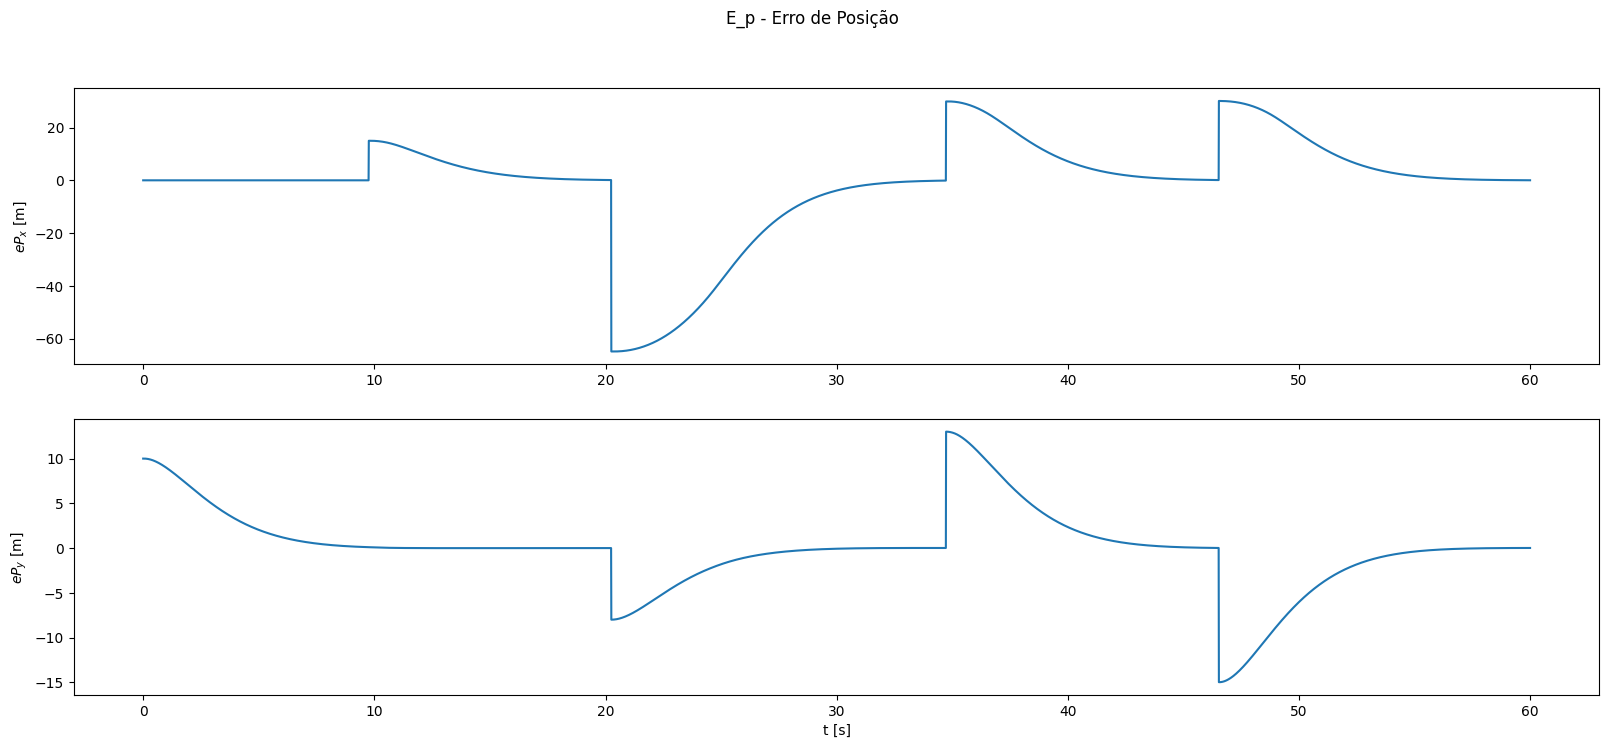

In [ ]:
plt.rcParams['figure.figsize'] = [50/2.54, 20/2.54]

plt.subplot(2, 1, 1)
plt.plot(td,eP_[0,:])
plt.ylabel('$eP_x$ [m]')
plt.subplot(2, 1, 2)
plt.plot(td,eP_[1,:])
plt.ylabel('$eP_y$ [m]')
plt.xlabel('t [s]')
plt.suptitle('E_p - Erro de Posição')

Text(0.5, 0.98, 'W - Velocidade de rotação dos rotores')

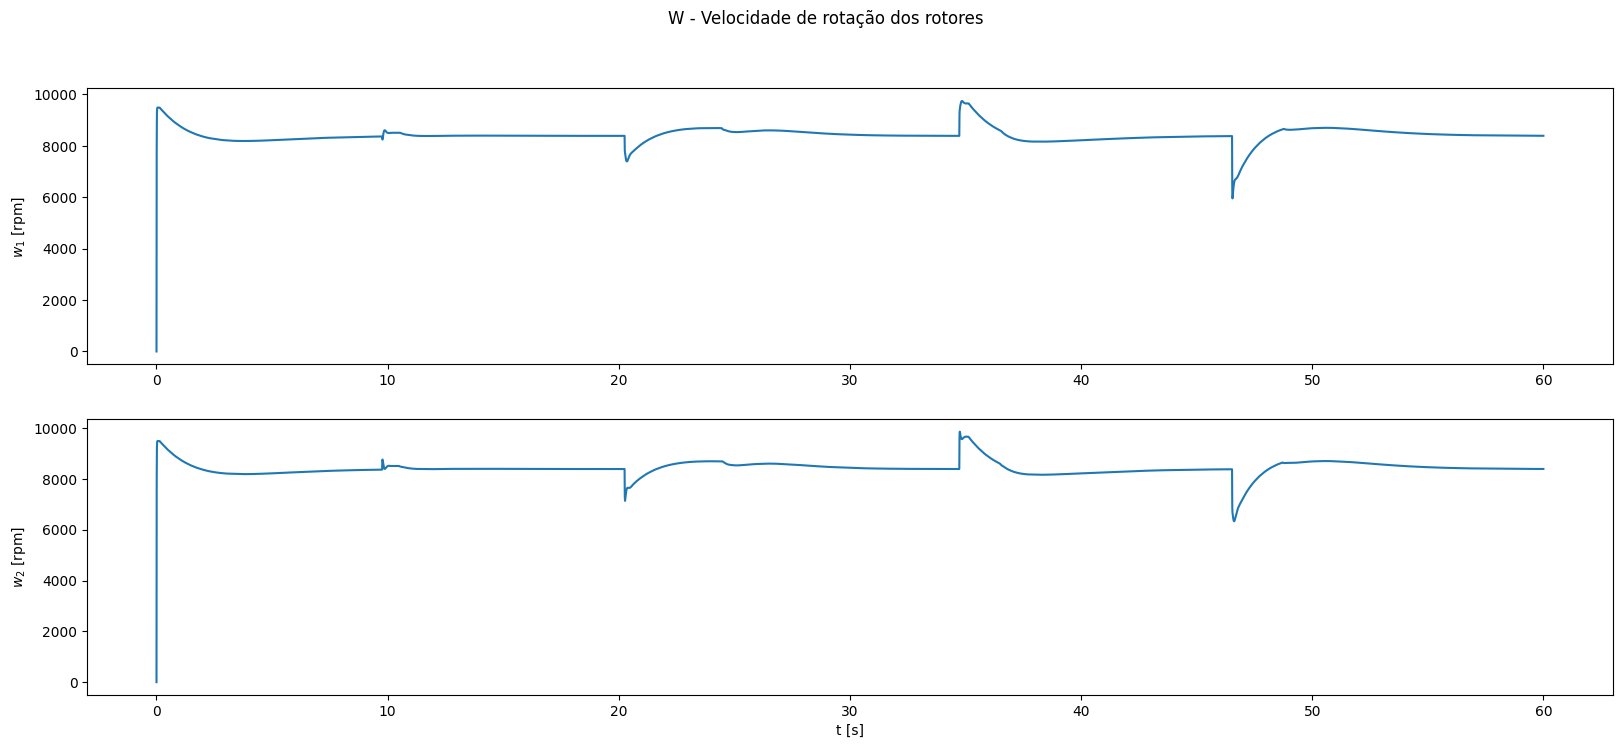

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(tc,x[0,:])
plt.ylabel('$w_1$ [rpm]')
plt.subplot(2, 1, 2)
plt.plot(tc,x[1,:])
plt.ylabel('$w_2$ [rpm]')
plt.xlabel('t [s]')
plt.suptitle('W - Velocidade de rotação dos rotores')

Text(0.5, 0.98, 'Força dos rotores')

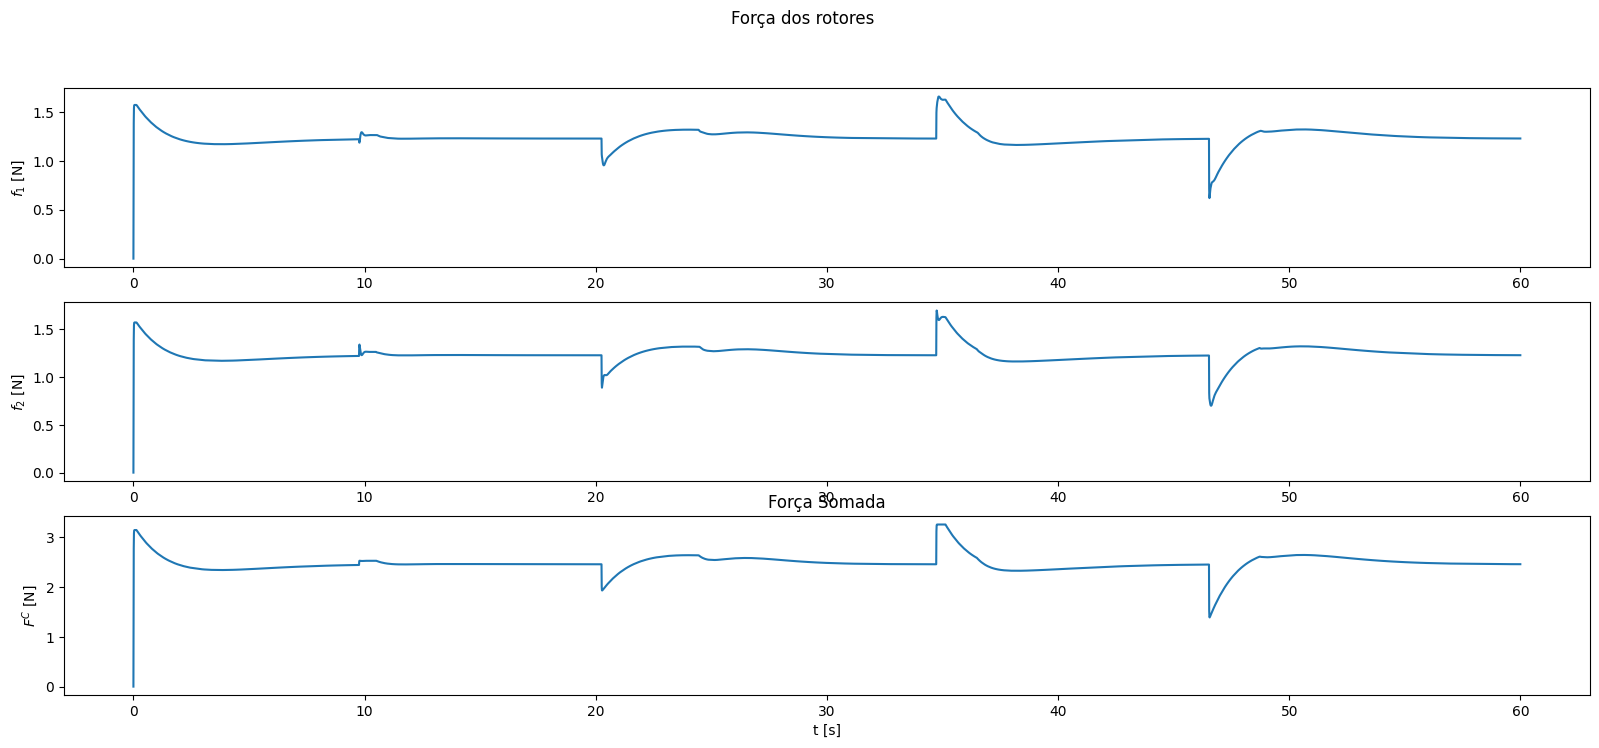

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(tc,f[0,:])
plt.ylabel('$f_1$ [N]')
plt.subplot(3, 1, 2)
plt.plot(tc,f[1,:])
plt.ylabel('$f_2$ [N]')

plt.subplot(3, 1, 3)
plt.title('Força Somada')
plt.plot(tc,f[2,:])
plt.ylabel('$F^C$ [N]')
plt.xlabel('t [s]')
plt.suptitle('Força dos rotores')

Text(0.5, 0.98, 'Deslocamento x tempo')

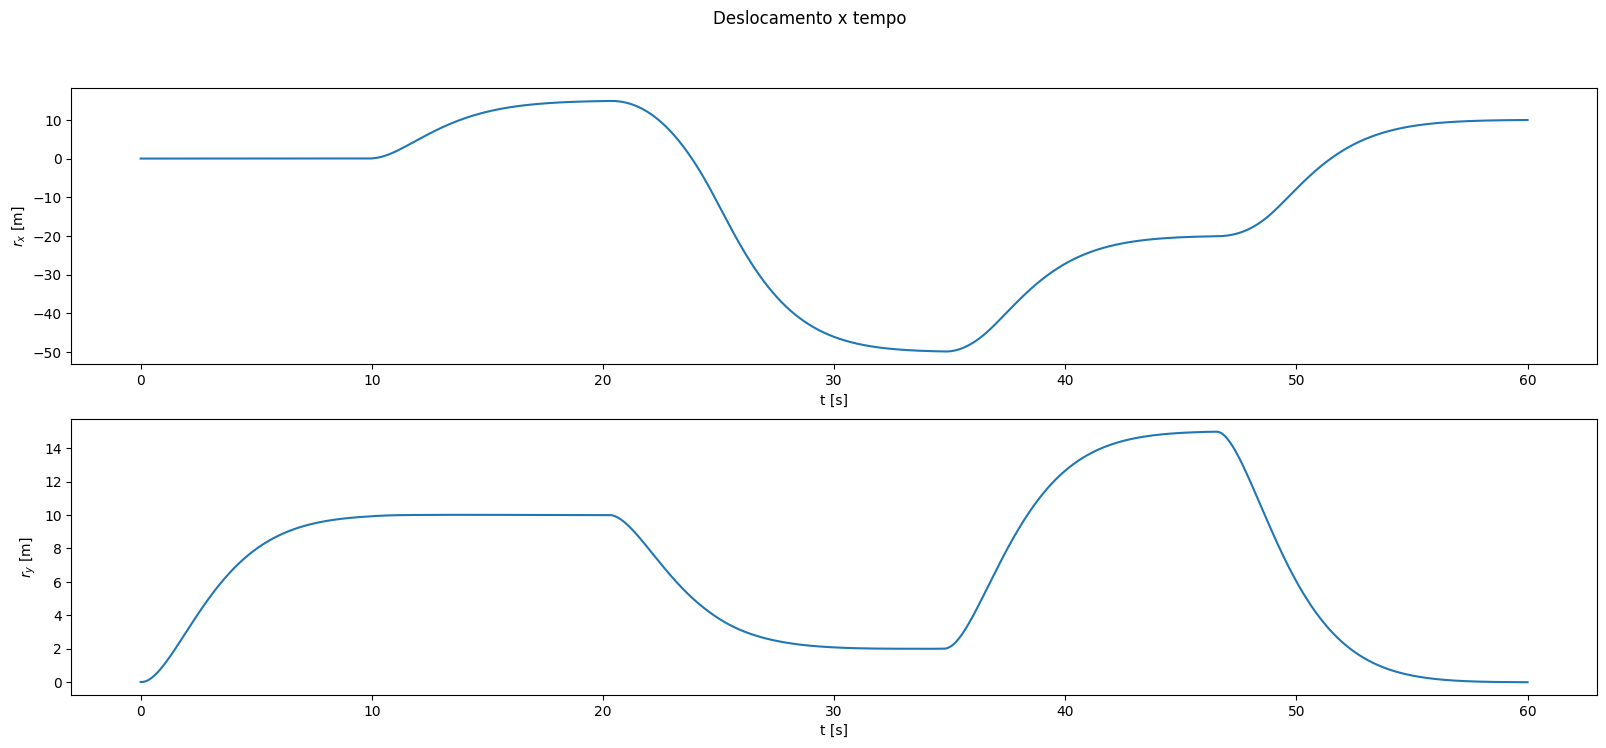

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(tc,x[2,:])
plt.ylabel('$r_x$ [m]')
plt.xlabel('t [s]')
plt.subplot(2, 1, 2)
plt.plot(tc,x[3,:])
plt.ylabel('$r_y$ [m]')
plt.xlabel('t [s]')
plt.suptitle('Deslocamento x tempo')

Text(0.5, 1.0, 'Deslocamento xy')

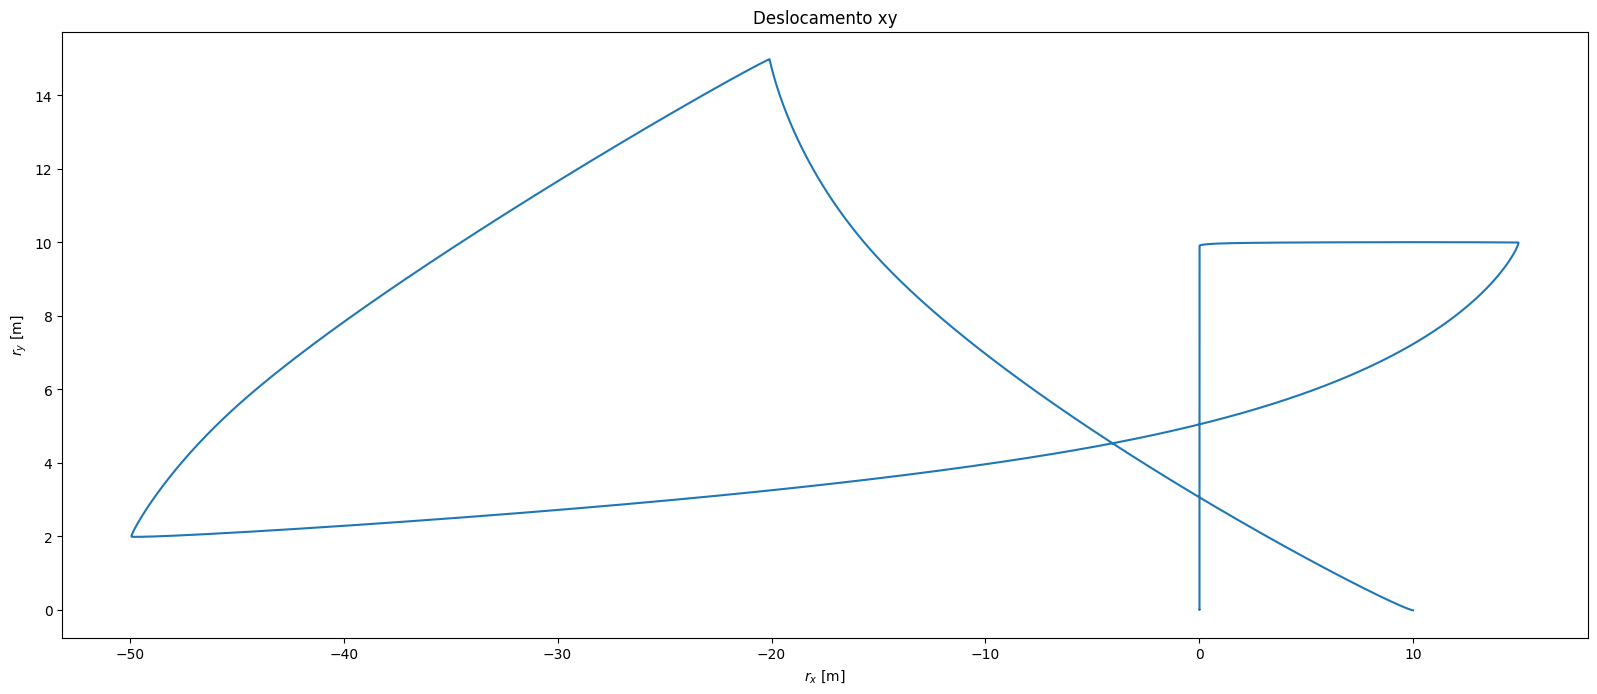

In [ ]:
plt.plot(x[2,:],x[3,:])
plt.ylabel('$r_y$ [m]')
plt.xlabel('$r_x$ [m]')
plt.title('Deslocamento xy')

Text(0.5, 0.98, 'Velocidade x tempo')

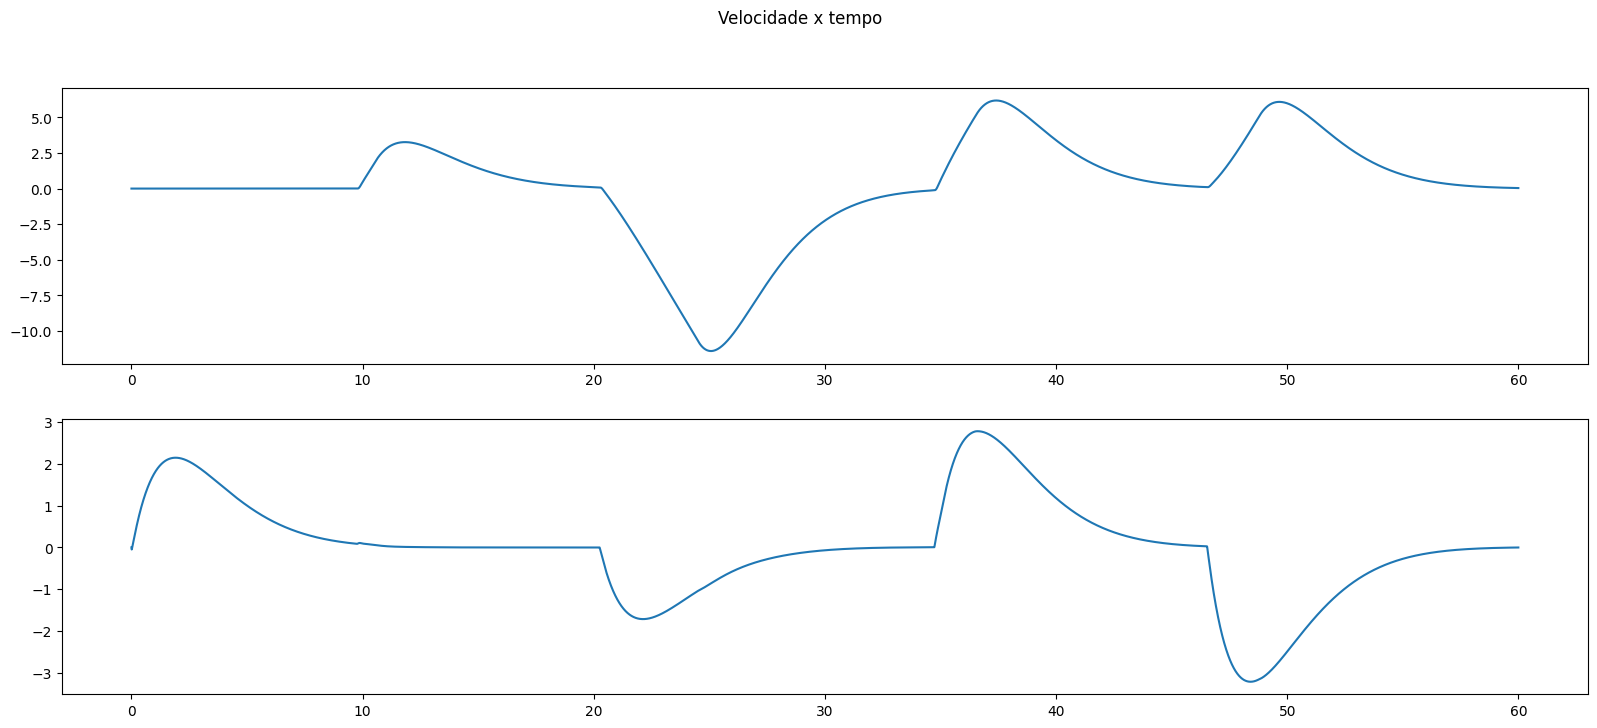

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(tc,x[4,:])
plt.subplot(2, 1, 2)
plt.plot(tc,x[5,:])
plt.suptitle('Velocidade x tempo')

Text(0.5, 0.98, 'Attitude x tempo')

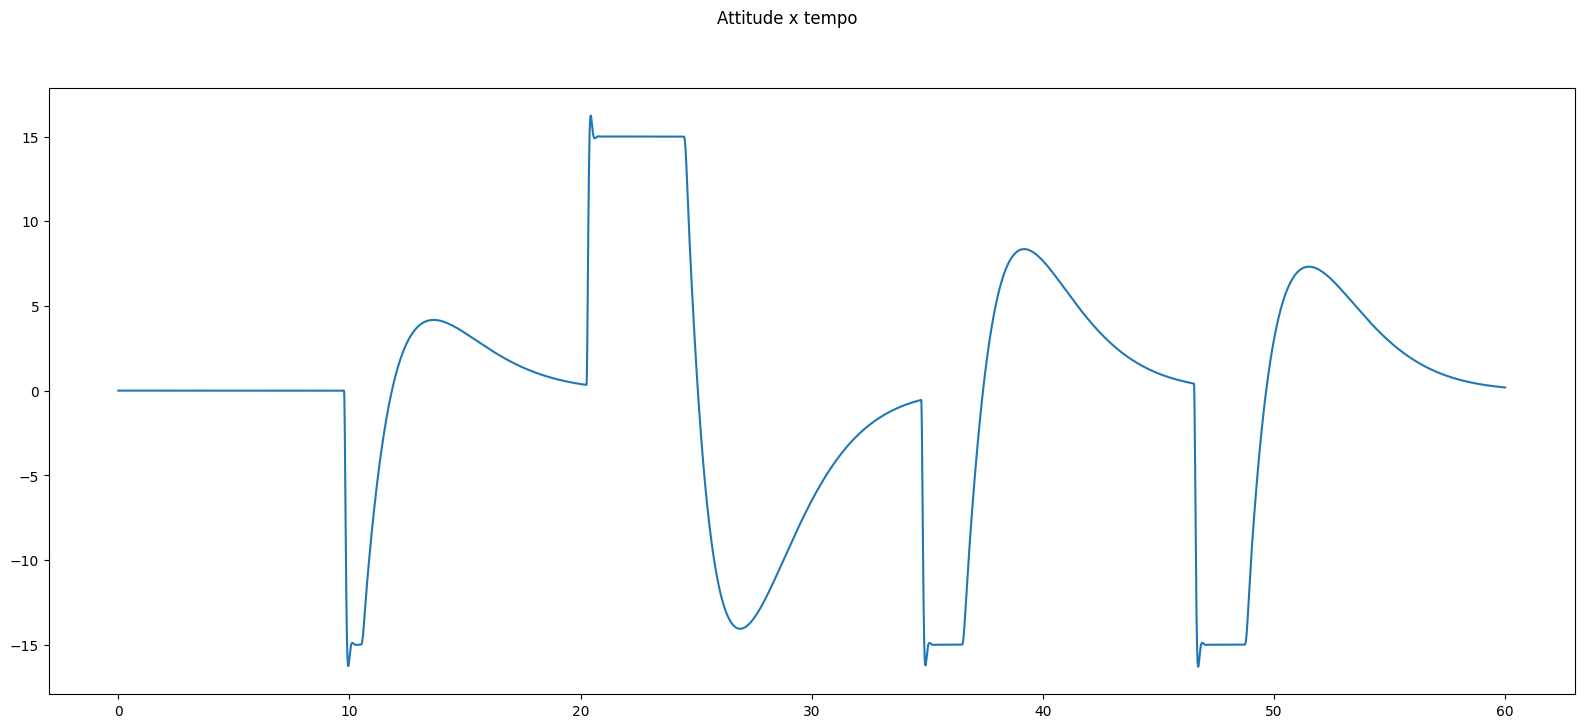

In [ ]:
plt.plot(tc, (x[6,:]*180/np.pi))
plt.suptitle('Attitude x tempo')

Text(0.5, 0.98, 'Velocidade angular x tempo')

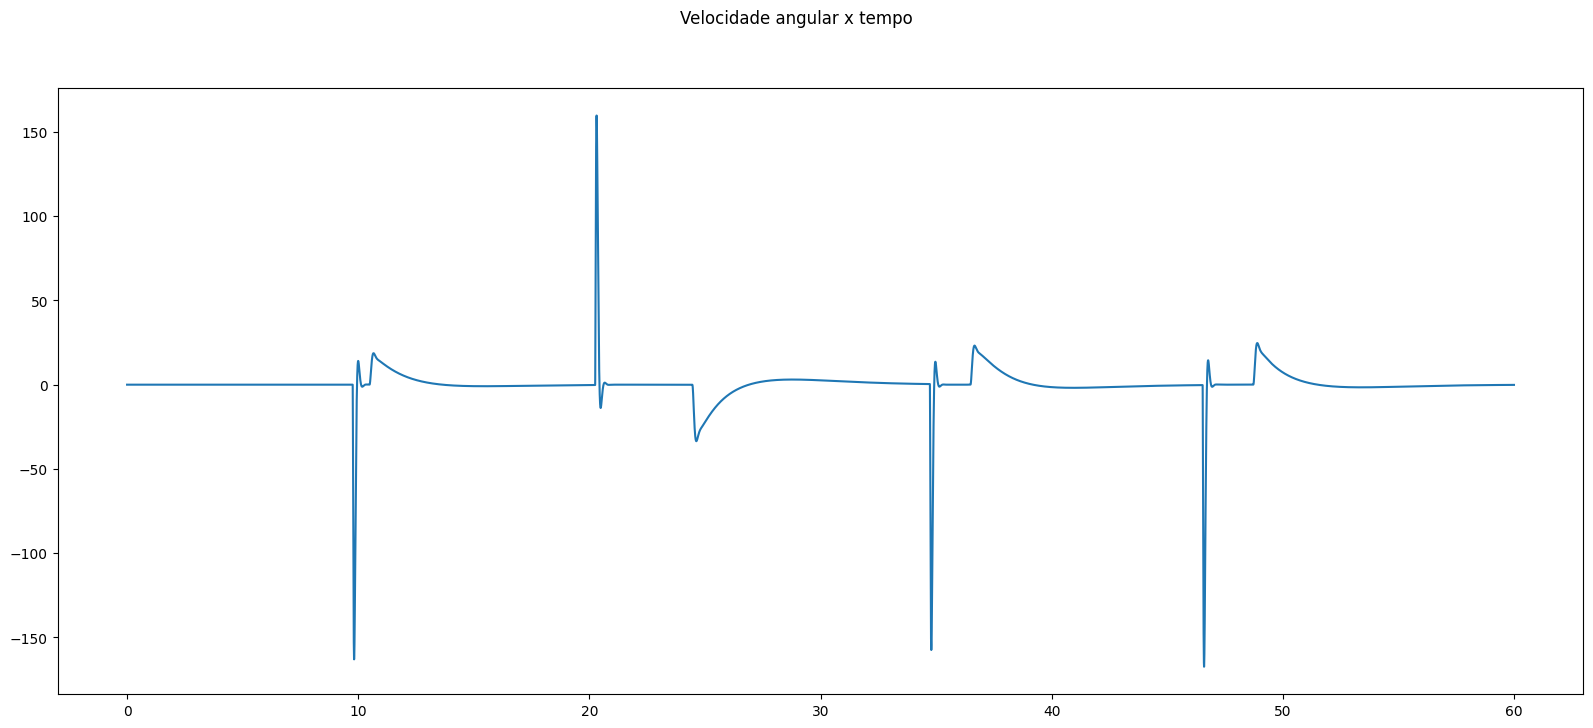

In [ ]:
plt.plot(tc,x[7,:]*180/np.pi)
plt.suptitle('Velocidade angular x tempo')